In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/classes-with-dont-care/classes_with_dont_care (1).json
/kaggle/input/labels-with-dont-care/005063.txt
/kaggle/input/labels-with-dont-care/000637.txt
/kaggle/input/labels-with-dont-care/002604.txt
/kaggle/input/labels-with-dont-care/004229.txt
/kaggle/input/labels-with-dont-care/000360.txt
/kaggle/input/labels-with-dont-care/006439.txt
/kaggle/input/labels-with-dont-care/002979.txt
/kaggle/input/labels-with-dont-care/005938.txt
/kaggle/input/labels-with-dont-care/007127.txt
/kaggle/input/labels-with-dont-care/000870.txt
/kaggle/input/labels-with-dont-care/007419.txt
/kaggle/input/labels-with-dont-care/006003.txt
/kaggle/input/labels-with-dont-care/004343.txt
/kaggle/input/labels-with-dont-care/007478.txt
/kaggle/input/labels-with-dont-care/006338.txt
/kaggle/input/labels-with-dont-care/003708.txt
/kaggle/input/labels-with-dont-care/004396.txt
/kaggle/input/labels-with-dont-care/003697.txt
/kaggle/input/labels-with-dont-care/002801.txt
/kaggle/input/labels-with-dont-care/00

In [2]:
pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 690.7 kB/s eta 0:00:000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 6.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import shutil
from PIL import Image

In [4]:
base_dir = Path('/kaggle/input/kitti-dataset')
img_path = base_dir / 'data_object_image_2' / 'training' / 'image_2'
label_path = Path('/kaggle/input/labels-with-dont-care')
with open('/kaggle/input/classes-with-dont-care/classes_with_dont_care (1).json','r') as f:
    classes = json.load(f)

classes

{'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7,
 'DontCare': 8}

In [8]:
# Get sorted lists of image and label file paths
sorted_image_paths = sorted(list(img_path.glob('*')))
sorted_label_paths = sorted(list(label_path.glob('*')))

# Pair corresponding image and label paths together
pairs = list(zip(sorted_image_paths, sorted_label_paths))

# Select the first two pairs for demonstration
pairs[:2]


[(PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000000.png'),
  PosixPath('/kaggle/input/labels-with-dont-care/000000.txt')),
 (PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000001.png'),
  PosixPath('/kaggle/input/labels-with-dont-care/000001.txt'))]

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(pairs,test_size=0.1,shuffle=True)
len(train), len(test)

(6732, 749)

In [11]:
train_path = Path('train').resolve()
train_path.mkdir(exist_ok=True)
valid_path = Path('valid').resolve()
valid_path.mkdir(exist_ok=True)

In [12]:
for t_img, t_lb in tqdm(train):
    im_path = train_path / t_img.name
    lb_path = train_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/6732 [00:00<?, ?it/s]

In [13]:
for t_img, t_lb in tqdm(test):
    im_path = valid_path / t_img.name
    lb_path = valid_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/749 [00:00<?, ?it/s]

In [14]:
# Prepare YAML content
yaml_file = 'names:\n'  # Start YAML file with 'names:' key
yaml_file += '\n'.join(f'- {c}' for c in classes)  # Add each class as a YAML list item under 'names:'
yaml_file += f'\nnc: {len(classes)}'  # Add number of classes as 'nc' key
yaml_file += f'\ntrain: {str(train_path)}\nval: {str(valid_path)}'  # Add paths for training and validation data

# Write YAML content to file
with open('kitti.yaml', 'w') as f:
    f.write(yaml_file)  # Write YAML content to the file


In [15]:
model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 69.0MB/s]


In [16]:
train_results = model.train(
    data='/kaggle/working/kitti.yaml', 
    epochs=50,
    patience=3,
    mixup=0.1,
    project='yolov8n-kitti',
    device=0
)

Ultralytics YOLOv8.2.31 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/kitti.yaml, epochs=50, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolov8n-kitti, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]
2024-06-13 05:49:30,748	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-13 05:49:32,064	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/train... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:46<00:00, 145.43it/s]


train: New cache created: /kaggle/working/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/valid... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:04<00:00, 151.13it/s]

val: New cache created: /kaggle/working/valid.cache


Plotting labels to yolov8n-kitti/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to yolov8n-kitti/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.61G      1.529      1.942      1.126        165        640: 100%|██████████| 421/421 [01:54<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.94it/s]


                   all        749       5207      0.569      0.311      0.336      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.51G      1.399       1.28       1.09        170        640: 100%|██████████| 421/421 [01:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.68it/s]


                   all        749       5207      0.428      0.426      0.406       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.8G      1.353      1.148      1.079        162        640: 100%|██████████| 421/421 [01:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


                   all        749       5207      0.514       0.42      0.455       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       2.5G      1.322      1.072      1.075        169        640: 100%|██████████| 421/421 [01:45<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.63it/s]

                   all        749       5207        0.5      0.492      0.494      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.65G      1.291       1.01      1.058        199        640: 100%|██████████| 421/421 [01:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]


                   all        749       5207      0.571      0.491      0.525       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.48G      1.261     0.9679       1.05        174        640: 100%|██████████| 421/421 [01:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.72it/s]


                   all        749       5207      0.542      0.534      0.548      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.68G      1.244     0.9317      1.042        256        640: 100%|██████████| 421/421 [01:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.85it/s]


                   all        749       5207      0.668      0.481      0.559      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.49G      1.228     0.9076      1.037        174        640: 100%|██████████| 421/421 [01:45<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]


                   all        749       5207      0.633      0.534      0.585      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.54G      1.215     0.8919      1.031        208        640: 100%|██████████| 421/421 [01:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


                   all        749       5207      0.704      0.519      0.599      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.76G      1.191      0.864      1.026        219        640: 100%|██████████| 421/421 [01:45<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.68it/s]


                   all        749       5207      0.653      0.539      0.598      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.72G      1.191     0.8635      1.025        201        640: 100%|██████████| 421/421 [01:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


                   all        749       5207      0.638       0.57      0.612      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.71G      1.173     0.8456      1.019        206        640: 100%|██████████| 421/421 [01:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.81it/s]


                   all        749       5207      0.686      0.575      0.633        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.63G      1.157     0.8249      1.011        141        640: 100%|██████████| 421/421 [01:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.73it/s]


                   all        749       5207       0.68      0.594      0.657      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.6G       1.15     0.8129      1.008        167        640: 100%|██████████| 421/421 [01:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.79it/s]


                   all        749       5207      0.675      0.606      0.646      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.6G      1.143     0.8085      1.006        165        640: 100%|██████████| 421/421 [01:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]


                   all        749       5207      0.753      0.561      0.661      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.63G      1.142     0.8039      1.005        191        640: 100%|██████████| 421/421 [01:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


                   all        749       5207      0.665      0.621      0.675      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.56G       1.13     0.7884      1.001        205        640: 100%|██████████| 421/421 [01:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


                   all        749       5207      0.688      0.614       0.67      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.57G      1.117     0.7808     0.9995        179        640: 100%|██████████| 421/421 [01:44<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


                   all        749       5207       0.74      0.597      0.677      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.64G      1.105     0.7682     0.9966        228        640: 100%|██████████| 421/421 [01:44<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


                   all        749       5207      0.741      0.611      0.686      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.75G      1.099     0.7635     0.9938        167        640: 100%|██████████| 421/421 [01:44<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


                   all        749       5207      0.703      0.637      0.689      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.48G      1.089     0.7511     0.9866        197        640: 100%|██████████| 421/421 [01:43<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.64it/s]


                   all        749       5207      0.779      0.602      0.701      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.64G      1.087     0.7469     0.9855        163        640: 100%|██████████| 421/421 [01:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


                   all        749       5207      0.808      0.589        0.7      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.67G       1.08     0.7373     0.9834        151        640: 100%|██████████| 421/421 [01:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.79it/s]


                   all        749       5207      0.755      0.659      0.719       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.57G      1.084     0.7428     0.9837        204        640: 100%|██████████| 421/421 [01:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


                   all        749       5207      0.781      0.617        0.7      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.8G      1.068      0.727     0.9802        231        640: 100%|██████████| 421/421 [01:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.73it/s]


                   all        749       5207      0.732      0.672      0.723      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.57G       1.06     0.7176     0.9761        149        640: 100%|██████████| 421/421 [01:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


                   all        749       5207      0.787      0.644      0.724      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.48G      1.058     0.7201     0.9763        228        640: 100%|██████████| 421/421 [01:45<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]

                   all        749       5207      0.743      0.677      0.735      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.58G      1.053     0.7163     0.9756        194        640: 100%|██████████| 421/421 [01:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


                   all        749       5207      0.791      0.648      0.737      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.73G      1.045     0.7048     0.9707        193        640: 100%|██████████| 421/421 [01:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.84it/s]


                   all        749       5207      0.746      0.678      0.738      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.72G      1.036     0.6945      0.967        158        640: 100%|██████████| 421/421 [01:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.71it/s]


                   all        749       5207       0.74      0.702      0.747        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.76G       1.04     0.6983      0.968        178        640: 100%|██████████| 421/421 [01:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]


                   all        749       5207      0.732      0.687      0.738      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.65G      1.027     0.6871     0.9633        154        640: 100%|██████████| 421/421 [01:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.79it/s]


                   all        749       5207      0.834       0.65      0.749      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.7G      1.018     0.6774     0.9625        175        640: 100%|██████████| 421/421 [01:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.67it/s]

                   all        749       5207      0.781      0.687      0.763      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.61G      1.013      0.675     0.9598        207        640: 100%|██████████| 421/421 [01:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]


                   all        749       5207      0.746      0.711      0.758      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.03G      1.012     0.6737     0.9595        200        640: 100%|██████████| 421/421 [01:44<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.69it/s]


                   all        749       5207       0.78      0.679      0.759      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.49G      1.014     0.6753     0.9604        106        640: 100%|██████████| 421/421 [01:45<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


                   all        749       5207      0.805      0.686      0.759      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.62G          1     0.6639     0.9544        227        640: 100%|██████████| 421/421 [01:45<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.67it/s]


                   all        749       5207      0.751      0.713      0.757       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.58G     0.9949      0.661     0.9522        170        640: 100%|██████████| 421/421 [01:44<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.69it/s]


                   all        749       5207      0.791      0.707      0.769      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.8G     0.9966     0.6656     0.9561        203        640: 100%|██████████| 421/421 [01:45<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.69it/s]


                   all        749       5207      0.809      0.696      0.774      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.77G     0.9848     0.6519     0.9509        230        640: 100%|██████████| 421/421 [01:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.63it/s]


                   all        749       5207      0.792      0.705       0.78      0.534
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.42G     0.9339     0.5876     0.9263         87        640: 100%|██████████| 421/421 [01:40<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.79it/s]


                   all        749       5207      0.794      0.706      0.774      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.3G     0.9195     0.5774      0.924        101        640: 100%|██████████| 421/421 [01:35<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.77it/s]


                   all        749       5207      0.768      0.717      0.777      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.3G     0.9069     0.5695     0.9182         52        640: 100%|██████████| 421/421 [01:35<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.79it/s]


                   all        749       5207      0.829      0.705      0.787      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.15G     0.8999     0.5645     0.9175         95        640: 100%|██████████| 421/421 [01:35<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]

                   all        749       5207      0.791      0.715      0.792      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.31G     0.8933     0.5588     0.9146        120        640: 100%|██████████| 421/421 [01:35<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]

                   all        749       5207      0.765       0.74      0.792      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.27G     0.8849     0.5565     0.9112         62        640: 100%|██████████| 421/421 [01:35<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.68it/s]


                   all        749       5207      0.798       0.72      0.796      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.3G     0.8809      0.549     0.9098         91        640: 100%|██████████| 421/421 [01:36<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.69it/s]

                   all        749       5207      0.825      0.722      0.801      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.15G     0.8762     0.5497     0.9071         86        640: 100%|██████████| 421/421 [01:36<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.71it/s]


                   all        749       5207      0.819       0.72      0.797      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.29G     0.8713     0.5442      0.907         71        640: 100%|██████████| 421/421 [01:35<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


                   all        749       5207      0.834      0.716      0.797      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.27G     0.8646     0.5383     0.9054         84        640: 100%|██████████| 421/421 [01:35<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]

                   all        749       5207      0.839      0.714      0.799      0.555



50 epochs completed in 1.552 hours.
Optimizer stripped from yolov8n-kitti/train/weights/last.pt, 6.2MB
Optimizer stripped from yolov8n-kitti/train/weights/best.pt, 6.2MB

Validating yolov8n-kitti/train/weights/best.pt...
Ultralytics YOLOv8.2.31 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.19it/s]


                   all        749       5207      0.841      0.714        0.8      0.555
                   Car        673       2878       0.91      0.904      0.953       0.77
            Pedestrian        178        450      0.831      0.682      0.778      0.444
                   Van        222        293      0.855      0.822       0.91        0.7
               Cyclist        116        164      0.876      0.731      0.803      0.507
                 Truck         96        100      0.957       0.95      0.972      0.779
                  Misc         79        100       0.92       0.71      0.825      0.552
                  Tram         32         56      0.861      0.911      0.956      0.732
        Person_sitting         11         26      0.774      0.615      0.755      0.439
              DontCare        543       1140      0.584      0.102      0.243     0.0748
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to yolov8n-kit

In [17]:
import shutil

# Specify the folder you want to zip
folder_to_zip = '/kaggle/working/yolov8n-kitti/train/weights'
# Specify the name of the output zip file
output_zip_file = 'weights.zip'

# Create a zip archive of the specified folder
shutil.make_archive(output_zip_file.replace('.zip', ''), 'zip', folder_to_zip)

print(f"Folder '{folder_to_zip}' has been successfully zipped into '{output_zip_file}'")


Folder '/kaggle/working/yolov8n-kitti/train/weights' has been successfully zipped into 'weights.zip'


In [18]:
valid_results = model.val()

Ultralytics YOLOv8.2.31 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/valid.cache... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:13<00:00,  3.59it/s]


                   all        749       5207      0.839      0.712      0.799      0.557
                   Car        673       2878      0.911      0.904      0.953      0.769
            Pedestrian        178        450      0.827      0.681      0.778      0.445
                   Van        222        293      0.853      0.819       0.91        0.7
               Cyclist        116        164      0.868      0.722      0.802      0.508
                 Truck         96        100      0.958       0.95      0.972      0.785
                  Misc         79        100      0.921       0.71      0.824      0.554
                  Tram         32         56      0.864      0.911      0.956      0.734
        Person_sitting         11         26       0.78      0.615      0.755      0.446
              DontCare        543       1140      0.572     0.0973       0.24     0.0744
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to yolov8n-kit

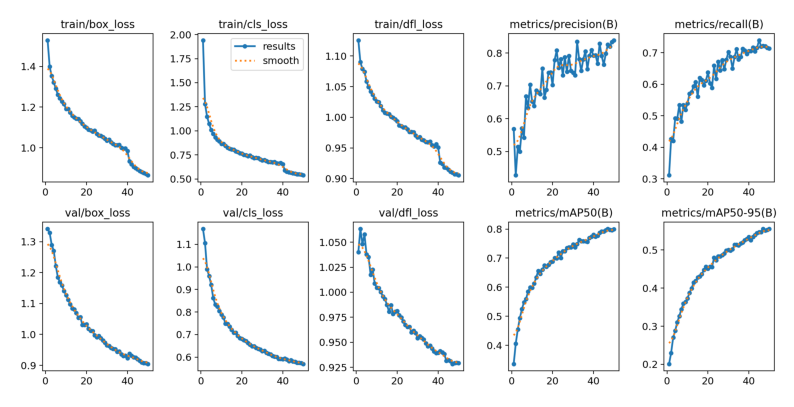

In [19]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/yolov8n-kitti/train/results.png'))
plt.axis('off')
plt.show()

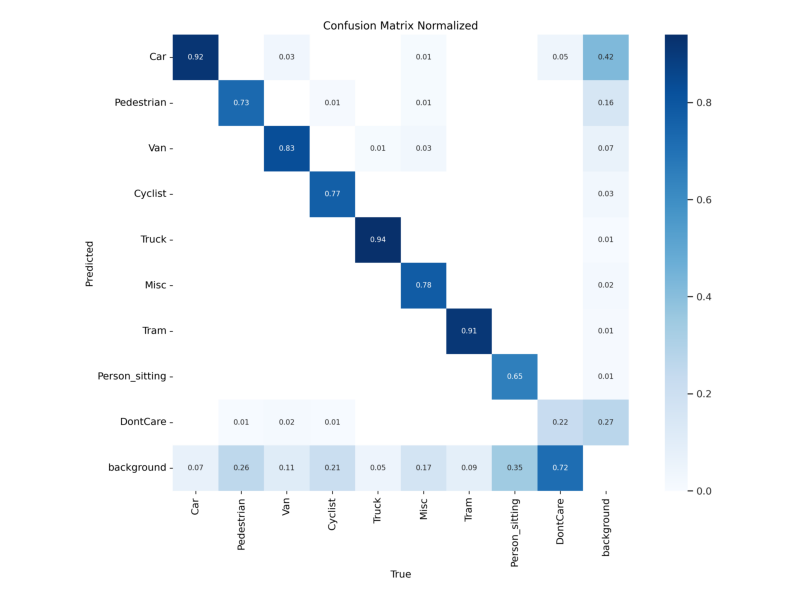

In [21]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/yolov8n-kitti/train/confusion_matrix_normalized.png'))
plt.axis('off')
plt.show()